# Variational Autoencoder Image Generation on MNIST

In this notebook we wish to train a VAE on the MNIST images and evaluate the quality of reconstructed images 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as ssim
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Downloading the data:

In [2]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data',
                                     train = False,
                                     download = True,
                                     transform = transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.09MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
x_train = trainset.data.numpy()
x_val = testset.data[:1000].numpy()
x_test = testset.data[1000:].numpy()

## Dataset and Dataloaders:

In [4]:
class CustomDataset(Dataset):
    def __init__(self, img):
        self.img = img

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        return image

In [5]:
train_dataset = CustomDataset(x_train)
test_dataset = CustomDataset(x_test)
val_dataset = CustomDataset(x_val)


train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=32)
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          batch_size=32)
val_loader = DataLoader(val_dataset,
                        shuffle=True,
                        batch_size=32)

# Model definition:

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder_conv = nn.Sequential(  #Encoder
            nn.Conv2d(1, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(512, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_sigma = nn.Linear(128, 2)

        self.fc2 = nn.Linear(2, 256)  #Decoder
        self.fc3 = nn.Linear(256, 4 * 4 * 32)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1),
            nn.Sigmoid()
        )


    def encoder(self, x):
        h = torch.tanh(self.fc1(self.encoder_conv(x)))
        return self.fc_mu(h), self.fc_sigma(h) # mu, std

    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc2(z))
        h = F.relu(self.fc3(h))
        h = self.decoder_conv(h)
        return h

    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

In [7]:
model = VAE()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

def loss_function(y, x, mu, std):
    bce_loss = nn.BCELoss(reduction='sum')
    ERR = bce_loss(y.view(-1, 784), x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + torch.log(std**2 + 1e-8) - mu**2 - std**2)

    return ERR + KLD, ERR, KLD

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [9]:
early_stopping = EarlyStopping(patience=10, delta=0)

# Training loop:

In [10]:
train_err_loss, train_kld_loss, val_total_loss = [], [], []
model.to(device)

for epoch in range(1, 100):

    train_loss = 0
    model.train()
    for images in train_loader:

        images = images.to(device).unsqueeze(1).type(torch.float32) / 255

        reconstructed_batch, mu, std = model(images)
        loss, err, kld = loss_function(reconstructed_batch, images, mu, std)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += err.item() + kld.item()

        train_err_loss.append(err.item()/32)
        train_kld_loss.append(kld.item()/32)


    model.eval()
    val_loss = 0
    for images in val_loader:

        images = images.to(device).unsqueeze(1).type(torch.float32) / 255

        reconstructed_batch, mu, std = model(images)
        loss, err, kld = loss_function(reconstructed_batch, images, mu, std)
        val_loss += err.item() + kld.item()
        val_total_loss.append(val_loss/32)

    train_loss /= (len(train_loader) * 32)
    val_loss /= (len(val_loader) * 32)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}')


Epoch: 1 | Train loss: 191.1410 | Validation loss: 162.6330
Epoch: 2 | Train loss: 161.6522 | Validation loss: 152.0480
Epoch: 3 | Train loss: 155.5951 | Validation loss: 148.5610
Epoch: 4 | Train loss: 152.3157 | Validation loss: 148.0154
Epoch: 5 | Train loss: 151.8894 | Validation loss: 147.1247
Epoch: 6 | Train loss: 150.1405 | Validation loss: 147.9288
Epoch: 7 | Train loss: 149.0335 | Validation loss: 147.0596
Epoch: 8 | Train loss: 149.0857 | Validation loss: 146.1266
Epoch: 9 | Train loss: 148.2566 | Validation loss: 146.2459
Epoch: 10 | Train loss: 147.9751 | Validation loss: 146.3677
Epoch: 11 | Train loss: 147.8522 | Validation loss: 145.6987
Epoch: 12 | Train loss: 147.3692 | Validation loss: 143.2816
Epoch: 13 | Train loss: 147.1339 | Validation loss: 143.4454
Epoch: 14 | Train loss: 146.7042 | Validation loss: 143.2711
Epoch: 15 | Train loss: 146.0957 | Validation loss: 141.4231
Epoch: 16 | Train loss: 146.3584 | Validation loss: 141.8565
Epoch: 17 | Train loss: 146.7218 

In [11]:
early_stopping.load_best_model(model)

# Model's loss on the test set:

In [12]:
model.eval()
test_loss = 0
for images in test_loader:

    images = images.to(device).unsqueeze(1).type(torch.float32) / 255

    reconstructed_batch, mu, std = model(images)
    loss, err, kld = loss_function(reconstructed_batch, images, mu, std)
    test_loss += err.item() + kld.item()

test_loss /= (len(test_loader) * 32)

print(f'Test loss: {test_loss:.4f}')

Test loss: 144.1002


# Visualizing the reconstructions of the model:

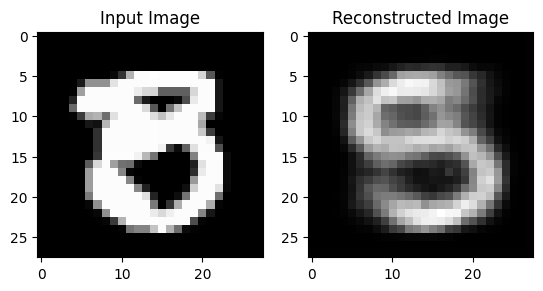

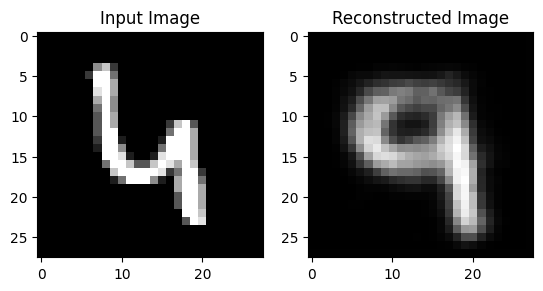

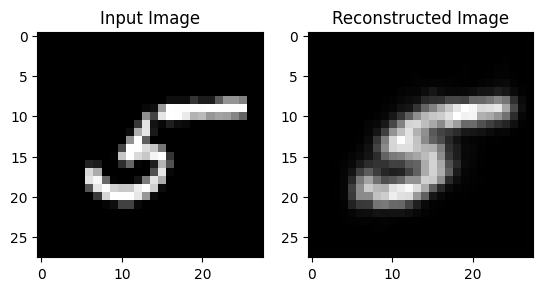

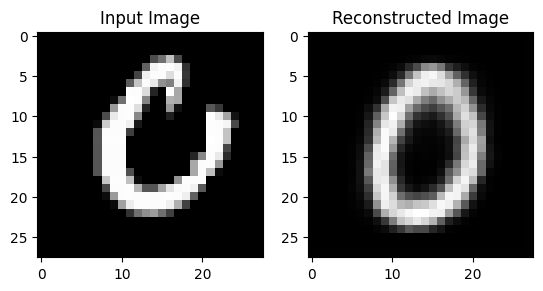

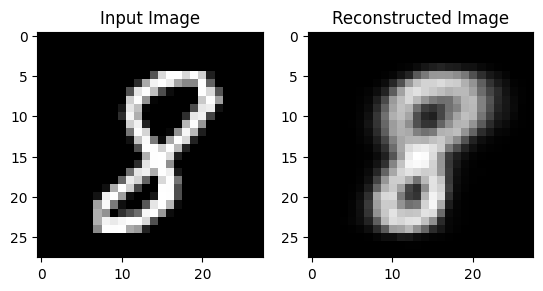

In [13]:
model.eval()
for i in range(5):
  images = next(iter(train_loader))

  images = images.to(device).unsqueeze(1).type(torch.float32) / 255
  reconstructed, mu, std = model(images)
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(images[0].permute(1,2,0).detach().cpu().numpy(), cmap="gray")
  axarr[0].set_title("Input Image")
  axarr[1].imshow(reconstructed[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
  axarr[1].set_title("Reconstructed Image")
    

## Visualizing Distribution:

In [14]:
model.eval()
samples_x = []
samples_y = []

label = testset.targets[:5000]

for i in range(5000):
    image = testset.data[i]
    image = image.to(device).reshape(1,1,28,-1).type(torch.float32) / 255
    
    mu, std = model.encoder(image)
    sample = model.sampling(mu, std).squeeze()

    samples_x.append(sample[0].item())
    samples_y.append(sample[1].item())

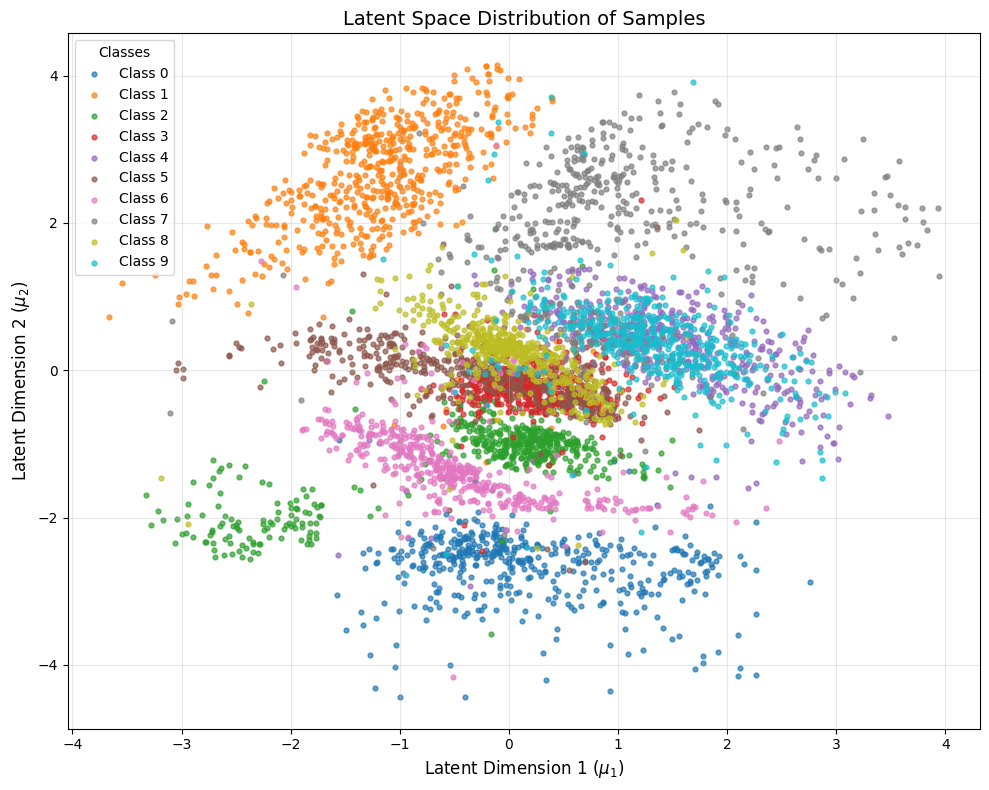

In [15]:
samples_x = np.array(samples_x)
samples_y = np.array(samples_y)
classes = np.unique(label)
colors = plt.get_cmap('tab10', len(classes))

plt.figure(figsize=(10, 8))
for class_idx in classes:
    
    class_mask = (label == class_idx)
    
    plt.scatter(samples_x[class_mask], 
                samples_y[class_mask],
                label=f'Class {class_idx}', 
                alpha=0.7, 
                s=12,
                c=[colors(class_idx)]) 

plt.title("Latent Space Distribution of Samples", fontsize=14)
plt.xlabel("Latent Dimension 1 ($\mu_1$)", fontsize=12)
plt.ylabel("Latent Dimension 2 ($\mu_2$)", fontsize=12)
plt.legend(title="Classes")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


## Visualizing random generated samples:

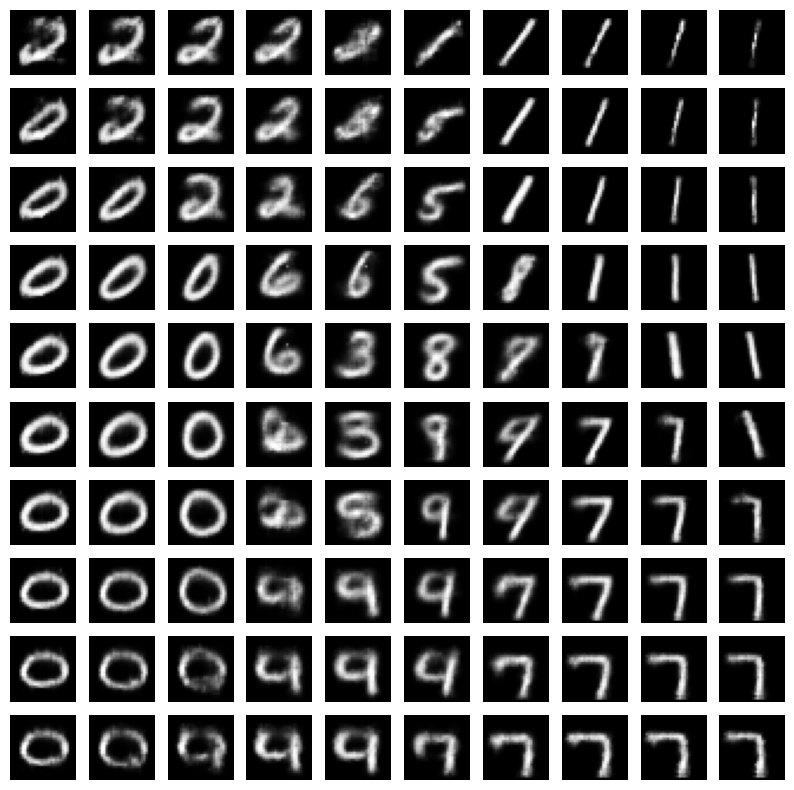

In [16]:
rows, columns = 10,10
mu, std = np.linspace(samples_x.min(), samples_x.max(), columns), np.linspace(samples_y.min(), samples_y.max(), rows)
mu_grid, std_grid = np.meshgrid(mu, std, indexing='ij') 

model.eval()
plt.figure(figsize=(10,10))
with torch.no_grad():
    for i in range(rows):
        for j in range(columns):
            z = torch.tensor([mu_grid[i, j], std_grid[i, j]]).unsqueeze(0).to(device).to(torch.float32)
            gen_img = model.decoder(z)
            plt.subplot(rows, columns, i * columns + j + 1)
            plt.imshow(gen_img[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            plt.axis(False)

plt.show()

## Mixed Visualization:

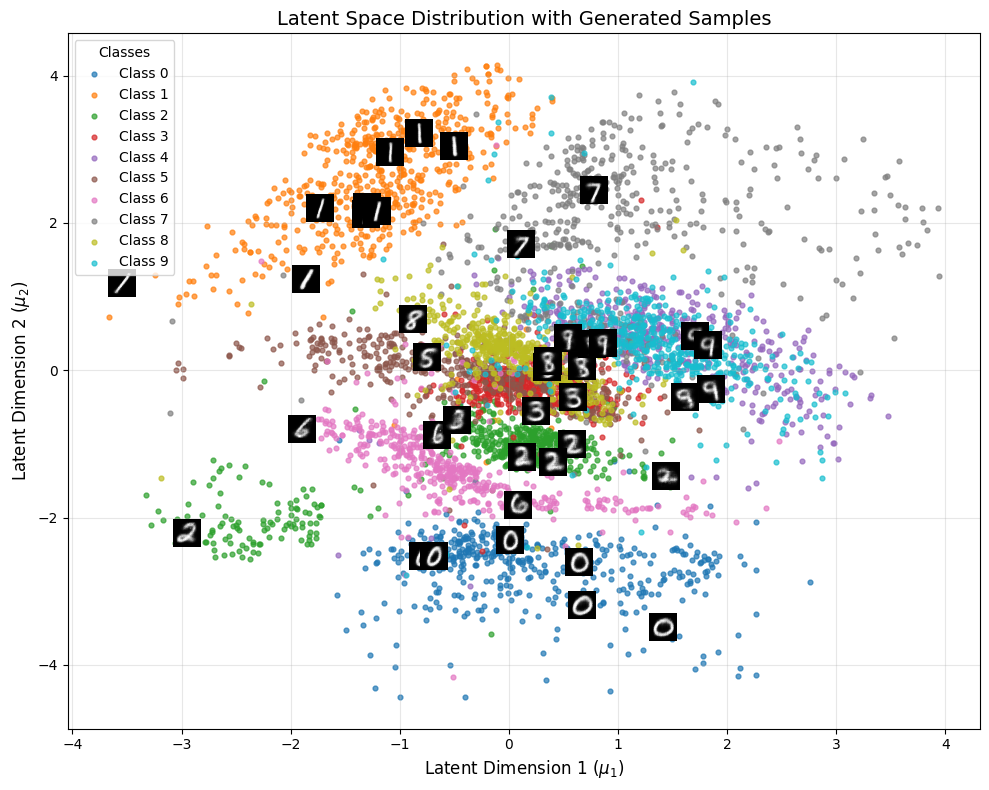

In [17]:
plt.figure(figsize=(10, 8))
for class_idx in classes:
    class_mask = (label == class_idx)
    plt.scatter(samples_x[class_mask], 
                samples_y[class_mask],
                label=f'Class {class_idx}', 
                alpha=0.7, 
                s=12,
                c=[colors(class_idx)]) 

selected_points = np.random.choice(len(samples_x), size=40, replace=False)

model.eval()
with torch.no_grad():
    for idx in selected_points:
        z = torch.tensor([samples_x[idx], samples_y[idx]]).unsqueeze(0).to(device).to(torch.float32)
        gen_img = model.decoder(z).cpu().numpy().squeeze()

        imagebox = OffsetImage(gen_img, cmap='gray', zoom=0.7)
        ab = AnnotationBbox(imagebox, (samples_x[idx], samples_y[idx]), frameon=False)
        plt.gca().add_artist(ab)

plt.title("Latent Space Distribution with Generated Samples", fontsize=14)
plt.xlabel("Latent Dimension 1 ($\mu_1$)", fontsize=12)
plt.ylabel("Latent Dimension 2 ($\mu_2$)", fontsize=12)
plt.legend(title="Classes")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Measuring the quality of reconstructed images:

In [18]:
ssim_metric = ssim(data_range=1.0).to("cuda")

def compute_mae(denoised, ground_truth):
    mae = torch.mean(torch.abs(denoised - ground_truth))
    return mae

In [19]:
model.eval()
mae_loss = 0
ssim_similarity = 0
for images in test_loader:

    images = images.to(device).unsqueeze(1).type(torch.float32) / 255

    reconstructed_batch, mu, std = model(images)
    similarity = ssim_metric(reconstructed_batch, images)
    loss = compute_mae(reconstructed_batch, images) * 255
    
    mae_loss += loss.item()
    ssim_similarity += similarity.item()

ssim_similarity /= (len(test_loader))
mae_loss /= (len(test_loader))

print(f'SSIM of reconstructed images in Test set: {ssim_similarity:.4f}\nMAE loss: {mae_loss:.4f}')

SSIM of reconstructed images in Test set: 0.6561
MAE loss: 23.2057
